# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *
from NLMixedUtils.plotting import *
# pd.set_option('display.max_rows', None)



/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/home/seuss/anaconda3/e

# Load/Save All Data

In [2]:
plotparams={
    'mod_titles':   ['Mot','Vis','Add','Mul','HF','VisNoShifter'],
    'mod_clrs':     ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"],
    'dates_all':    ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT'],
}
plotparams['date_ani2'] = [plotparams['dates_all'][n].replace('/','_') for n in range(len(plotparams['dates_all']))]


In [3]:
params['do_shuffle']=True
params['complex']     = False
params['nt_glm_lag']=5
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
Shuff_List = []
for date_ani in dates_all:
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    Shuff_List.append(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ((('CropInputs' in path.parts) | ('complex' in path.parts)) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem))]))

    # mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best.h5'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    # Shuff_List.append(list((params['save_dir'].parent.parent.parent / date_ani).rglob(mod_name)))
Shuff_List = np.stack(Shuff_List)
# Shuff_List

In [28]:
Kfold = 0
args['free_move']=True
# mod_titles = ['Mot','Vis','Add','Mul','HF','VisNoShifter']
# mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
# dates_all = ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,nsp_raw_all,hf_nsp_all,model_move_FM,model_move_HF,ax_lims_all,move_test_all,test_nsp_all = [], [], [],[], [], [], [], [], [], [], [], [], []

for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if  (('CropInputs' in path.parts) | ('complex' in path.parts) | ('OnlySpdPupil' in path.parts))  & ('Laplace' not in path.stem)])) # (params['exp_name'] in path.as_posix()) &
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    params['use_spdpup']=True
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    move_test_all.append(move_test)
    ax_lims_all.append(ax_ylims)
    nsp_raw_all.append(nsp_raw)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
# ax_lims_all = np.stack(ax_lims_all)
# tuning_sig_all2 = np.hstack(tuning_sig_all2)
# tuning_sig_all = np.vstack(tuning_sig_all)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)
ModelList_all = np.concatenate((ModelList_all,Shuff_List),axis=1)
# [mlist.as_posix() for mlist in ModelList_all.flatten()]

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)


In [39]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{'complex':{},'CropInputs':{}, 'complex_SpdPup':{},'CropInputs_SpdPup':{},'OnlySpdPupil':{}, } for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['model_move_FM'] = model_move_FM[da]
    All_data[date_ani]['tuning_sig'] = tuning_sig_all[da]
    All_data[date_ani]['model_move_FM'] = model_move_FM[da]
    All_data[date_ani]['model_move_HF'] = model_move_HF[da]
    All_data[date_ani]['move_test'] = move_test_all[da]
    All_data[date_ani]['nsp_raw'] = nsp_raw_all[da]
    All_data[date_ani]['ax_lims'] = ax_lims_all[da]
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for _,fmod in enumerate(ModelList_all[da]):
        if 'hf1_wn' in fmod.parts:
            ModelRun = 4
        else: 
            mtype = fmod.name.split('_')[2]
            ModelRun = [n for n,m in enumerate(plotparams['mod_titles']) if m == mtype][0]
        if ('complex' in fmod.parts):
            exp_type = 'complex'
        elif ('CropInputs' in fmod.parts):
            exp_type = 'CropInputs'
        elif ('OnlySpdPupil' in fmod.parts):
            exp_type = 'OnlySpdPupil' 
        if 'SpdPup' == fmod.name.split('_')[3]:
            exp_type = exp_type + '_SpdPup'

        VisName = plotparams['mod_titles'][1]
        ModelName = plotparams['mod_titles'][ModelRun]
        if 'shuffled'==fmod.name.split('_')[-2]:
            ModelName = ModelName + '_shuffled'
            VisName = VisName + '_shuffled'
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][exp_type][ModelName +'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][exp_type][ModelName +'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][exp_type][ModelName +'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][exp_type][ModelName+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4) | (ModelRun == 5):
            All_data[date_ani][exp_type][ModelName+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            if (exp_type =='complex')|(exp_type =='complex_SpdPup'):
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            else:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][exp_type][ModelName+'_rf_up'] = RF_all_up
            All_data[date_ani][exp_type][ModelName+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][exp_type][ModelName+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
            All_data[date_ani][exp_type][ModelName+'_moveBias'] = GLM_Data['posNN.Layer0.bias'].copy()
        if (ModelRun != 4):
            if 'shuffled'==fmod.name.split('_')[-2]:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = GLM_Data['cc_test'].copy()
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = GLM_Data['r2_test'].copy()
            else:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            if 'shuffled'==fmod.name.split('_')[-2]:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = GLM_Data['cc_test'].copy()
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = GLM_Data['r2_test'].copy()
            else:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani][exp_type]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][exp_type][VisName+'_rf_all'][celln,2].flatten(),All_data[date_ani][exp_type][ModelName+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][exp_type][ModelName+'_FMHF_cc'] = r2_FMHF_RF
            
SimRF_file = '/home/seuss/Research/SensoryMotorPred_Data/data2/121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format('withL1',int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
SimRFfit_file = '/home/seuss/Research/SensoryMotorPred_Data/data2/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
SimFit_Data = ioh5.load(SimRFfit_file)
SimRF_Data = ioh5.load(SimRF_file)
RF_SimFit = SimFit_Data['Cell_NN.0.weight'].reshape((SimFit_Data['Cell_NN.0.weight'].shape[0],1,)+(30,40))
SimFit_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=SimFit_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_Data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])
Sim_cc = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1]) for celln in range(Sim_act_smooth.shape[0])])
Sim_RFcc = np.array([(np.corrcoef(SimRF_Data['RF_actual'][celln].flatten(),RF_SimFit[celln,0].flatten())[0, 1]) for celln in range(Sim_act_smooth.shape[0])])
Sim_dict = {'SimData': {'Simfit_smooth': SimFit_smooth,
                        'Simact_smooth': Sim_act_smooth,
                        'Sim_r2': Sim_r2,
                        'Sim_cc': Sim_cc,
                        'Sim_RFcc': Sim_RFcc,
                        'Simact_RF':SimRF_Data['RF_actual'],
                        'Simfit_RF':RF_SimFit, 
                        'Sim_yte': SimRF_Data['yte'],}}
All_data.update(Sim_dict)

All_data['tuning_sig_all'] = tuning_sig_all

celltypes_all = pd.read_hdf(params['base_dir'].parent.parent/'Data4_dataset.h5')

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
ioh5.save(params['save_dir'].parents[2]/'All_data_v2.h5',All_data)

Done Loading Unaligned data
Tot_units: (128,)


In [73]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
exp_type = 'CropInputs'
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
for da, date_ani in enumerate(dates_all):
    args['date_ani'] = dates_all[da]
    args['train_shifter']   = False
    args['NoL1']            = False
    args['NoL2']            = False
    args['reg_lap']         = False
    args['complex']         = False
    args['do_shuffle']      = False
    args['Nepochs']         = 10000
    params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), 5, params['Nepochs'],Kfold)
    ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
    args['train_shifter']   = False
    params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
    params['lag_list']     = [0]
    params['nt_glm_lag'] = len(params['lag_list'])
    if args['train_shifter']:
        params['lag_list']     = [0]
        params['nt_glm_lag']   = len(params['lag_list'])
        params['Nepochs']      = 5000
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

    ##### Set Train Test Splits #####
    Kfold = 0
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)

    params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
    print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, complex: {}'.format(
        params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))
    
    xtr = xtr.cpu().detach().numpy()
    ytr = ytr.cpu().detach().numpy()
    xte = xte.cpu().detach().numpy()
    yte = yte.cpu().detach().numpy()
    sta = (xtr.T @ ytr)/np.sum(ytr,0,keepdims=True)
    yte_pred = xte@sta
    sta_im = sta.T.reshape((ytr.shape[1],params['nt_glm_lag'],)+params['nks'])
    sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte)[params['bin_length']:-params['bin_length']]
    pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte_pred)[params['bin_length']:-params['bin_length']]
    cc_all = np.array([(np.corrcoef(yte[:,celln],yte_pred[:,celln])[0, 1]) for celln in range(yte.shape[1])])

    # sta_im,sp_smooth,pred_smooth,cc_all = compute_STA(xtr,xte,ytr,yte,params)
    All_data[date_ani2[da]][exp_type]['Vis_sta_im'] = sta_im
    All_data[date_ani2[da]][exp_type]['Vis_sta_sp_smooth'] = sp_smooth
    All_data[date_ani2[da]][exp_type]['Vis_sta_pred_smooth'] = pred_smooth
    All_data[date_ani2[da]][exp_type]['Vis_sta_cc_all'] = cc_all
ioh5.save(params['save_dir'].parents[2]/'All_data_v2.h5',All_data)

Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, complex: False
Done Loading Unaligned data
Tot_units: (67,)
Model: 1, LinMix: False, move_features: None, Ncells: 63, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, complex: False
Done Loading Unaligned data
Tot_units: (56,)
Model: 1, LinMix: False, move_features: None, Ncells: 45, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, complex: False
Done Loading Unaligned data
Tot_units: (71,)
Model: 1, LinMix: False, move_features: None, Ncells: 52, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, complex: False


In [75]:
ioh5.save(params['save_dir'].parents[2]/'All_data_v2.h5',All_data)

# Plotting

In [2]:
warnings.filterwarnings('ignore')
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['train_shifter']   = False
args['NoL1']            = False
args['NoL2']            = False
args['reg_lap']         = False
args['complex']         = False
args['do_shuffle']      = False
args['use_spdpup']      = False
args['Nepochs'] = 10000

params,file_dict,exp = load_params(MovModel,Kfold,args,{},debug=True)
params['lag_list']     = [-2,-1,-0,1,2]
params['nt_glm_lag']   = len(params['lag_list'])

pparams={
    'mod_titles':   ['Mot','Vis','Add','Mul','HF','VisNoShifter'],
    'mod_clrs':     ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"],
    'dates_all':    ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT'],
}
pparams['date_ani2'] = [pparams['dates_all'][n].replace('/','_') for n in range(len(pparams['dates_all']))]


In [3]:
celltypes_all = pd.read_hdf(params['base_dir'].parent.parent/'Data4_dataset.h5')
All_data = ioh5.load(params['save_dir'].parents[2]/'All_data_v2.h5')
exp_type = 'CropInputs'


# Figure 2

In [8]:
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_VisNoSh = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test'] for da in range(len(pparams['dates_all']))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))

In [9]:
np.mean(vals_Vis-vals_VisNoSh)

0.05315341087212385

In [17]:
cell = 0
RF_all_up = np.zeros((All_data['SimData']['Simact_RF'].shape[:1] + ( sf*(All_data['SimData']['Simact_RF'][cell].shape[-2]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]))))
for cell in range(All_data['SimData']['Simact_RF'][cell].shape[0]):
    RF_all_up = cv2.resize(All_data['SimData']['Simact_RF'][cell], (sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-2])))

In [16]:
All_data['SimData']['Simact_RF'][cell].shape

(30, 40)

In [6]:
cc_sta = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_cc_all'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
cc_all2 = np.stack((vals_Vis,cc_sta))
RF_all = np.stack((np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_all'][:,2,:,:] for da in range(len(pparams['dates_all']))]),np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_im'][:,0] for da in range(len(pparams['dates_all']))])))
RF_all[0,22].shape

(20, 30)

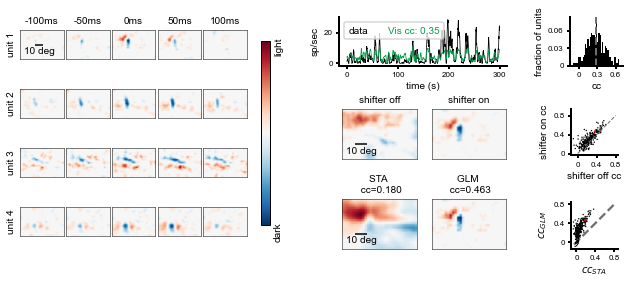

In [25]:
fig2_name = paper_fig_dir/'Figure2.pdf'
# figure2(All_data,pparams)
figure2(All_data,pparams,figname=fig2_name)

# Figure 3

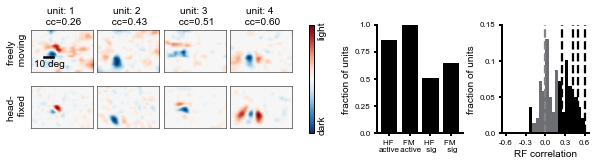

In [22]:
fig3_name = paper_fig_dir/'Figure3.pdf'
figure3(All_data,pparams)
# figure3(All_data,pparams,figname=fig3_name)

# Figure 4

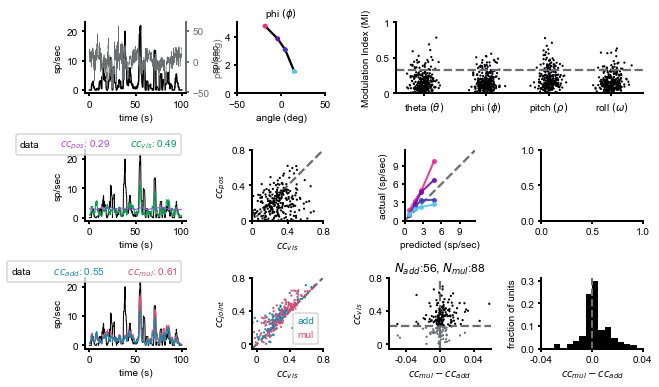

In [69]:
figure4(All_data,pparams,exp_type='CropInputs')
# figure4(All_data,pparams,exp_type='OnlySpdPupil')
# figure4(All_data,pparams,exp_type='CropInputs_SpdPup')
# figure4(All_data,pparams,exp_type='complex_SpdPup')
# figure4(All_data,pparams,exp_type='complex')


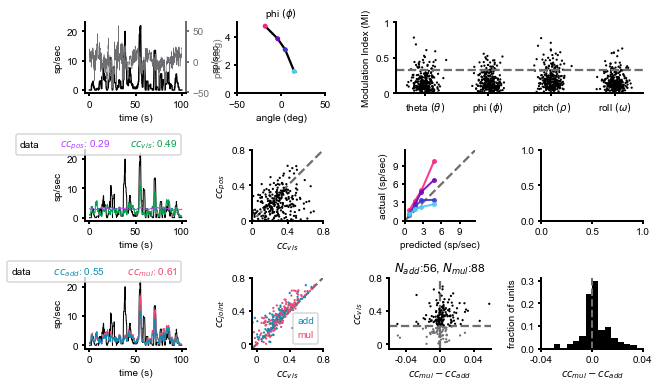

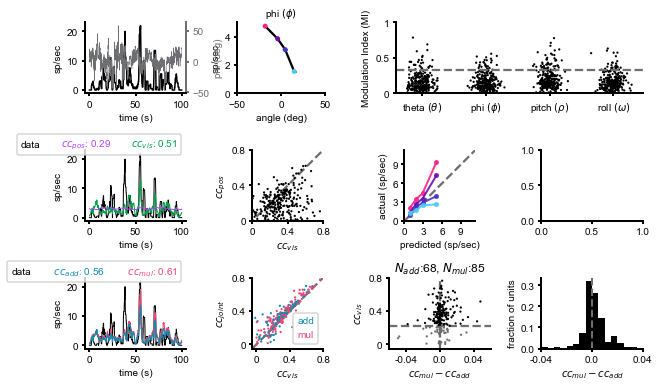

In [70]:
fig4_name = paper_fig_dir/'Figure4.pdf'
fig4_name_complex = paper_fig_dir/'Figure4_complex.pdf'
figure4(All_data,pparams,exp_type='CropInputs',figname=fig4_name)
figure4(All_data,pparams,exp_type='complex',figname=fig4_name_complex)

In [11]:
shuff_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])
shuff_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])
shuff_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])

In [61]:
exp_type = 'CropInputs'
vals_Add_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mot_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])


exp_type = 'OnlySpdPupil'
vals_Add_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mot_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])

exp_type = 'CropInputs_SpdPup'
vals_Vis_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])

In [63]:
np.nanmean(vals_Mot_CP)**2,np.nanmean(vals_Mot_OSP)**2,np.nanmean(vals_Vis_SP)**2,np.nanmean(vals_Mul_CP)**2,np.nanmean(vals_Mul_OSP)**2,np.nanmean(vals_Mul_SP)**2

(0.03962989855301378,
 0.03350035872987657,
 0.07907622531113005,
 0.10886436049635578,
 0.10674378269812757,
 0.12489608751417011)

In [ ]:
# Joint fit with weights 

## Celltype Info

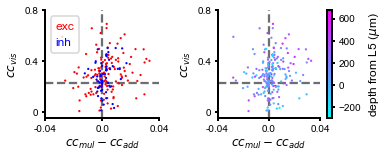

In [100]:
exp_type = 'CropInputs'
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_All = np.stack([vals_Mot,vals_Vis,vals_Mul-vals_Add])
ticks = [0,.4,.8]

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
vals_All = vals_All[move_r2_th]
c_cell_EI   = celltypes_all['exc_or_inh'][move_r2_th].factorize()[0]


##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0
c_cell_EI = c_cell_EI[th]
NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
fig, axs = plt.subplots(1,2,figsize=(5.5,2.3))
ax=axs[0]
im0 = ax.scatter(diff[th][c_cell_EI==0],increase[th][c_cell_EI==0],s=5,c='r',edgecolors='none')
im1 = ax.scatter(diff[th][c_cell_EI==1],increase[th][c_cell_EI==1],s=5,c='b',edgecolors='none')
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.04,.04)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)
legend1 = ax.legend(['exc','inh'],labelcolor=['r','b'],fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="upper left")

c_cell_depth =celltypes_all['Wn_depth_from_layer5'][move_r2_th]
ax=axs[1]
im = ax.scatter(diff[th],increase[th],s=5,c=c_cell_depth[th],cmap='cool',edgecolors='none')
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.04,.04)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)
cbar = add_colorbar(im)
cbar.set_label(r'depth from L5 ($\mu$m)',fontsize=fontsize)


  
plt.tight_layout()
# fig.savefig(paper_fig_dir/'CellType_Scatter.pdf', dpi=300, transparent=True, bbox_inches='tight')


In [103]:
vals_All.shape,c_cell_depth.shape

((3, 268), (213,))

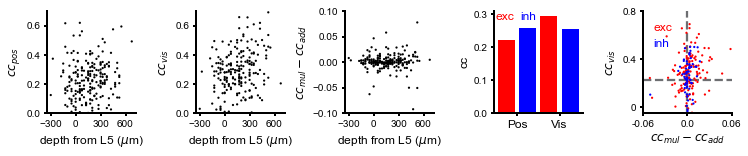

In [217]:
exp_type = 'CropInputs'
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_All = np.stack([vals_Mot,vals_Vis,vals_Mul-vals_Add])
fig, axs = plt.subplots(1,5,figsize=(10.5,2.3))
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis) & (vals_Vis>.22)) # (vals_Mot>.05) &  &

vals_All = vals_All[:,move_r2_th]
c_cell_depth =celltypes_all['Wn_depth_from_layer5'][move_r2_th]

labels = [r'$cc_{pos}$',r'$cc_{vis}$',r'$cc_{mul}-cc_{add}$']
for n in range(3):
    ax = axs[n]
    im=ax.scatter(c_cell_depth,vals_All[n],s=5,color='k',edgecolors='none')
    ax.set_xlabel(r'depth from L5 ($\mu$m)',fontsize=fontsize)
    ax.set_ylabel(labels[n], fontsize=fontsize)
    ax.set_xticks([-300,0,300,600])
    if n<2:
        ax.set_ylim([0,.7])
    else:
        ax.set_ylim(-.1,.1)
c_cell_EI   = celltypes_all['exc_or_inh'][move_r2_th].factorize()[0]

vals_exc = vals_All[:-1,c_cell_EI==0]
vals_inh = vals_All[:-1,c_cell_EI==1]
ax = axs[3]
ax.bar(np.arange(0,2*vals_exc.shape[0],2),np.nanmean(vals_exc,axis=1),color='r')
ax.bar(np.arange(1,2*vals_exc.shape[0]+1,2),np.nanmean(vals_inh,axis=1),color='b')
ax.set_xticks([.5,2.5])
ax.set_xticklabels(['Pos','Vis'],fontsize=fontsize)
ax.set_ylabel('cc',fontsize=fontsize)
legend1 = ax.legend(['exc','inh'],labelcolor=['r','b'],fontsize=fontsize,ncol=2, markerscale=0, handlelength=0, handletextpad=-1.5,loc="upper left",frameon=False, bbox_to_anchor=(.1, 1.1))

diff =( vals_Mul-vals_Add)[move_r2_th]
increase = vals_Vis[move_r2_th]
th = increase>0
c_cell_EI = c_cell_EI
ax=axs[4]
im0 = ax.scatter(diff[c_cell_EI==0],increase[c_cell_EI==0],s=5,c='r',edgecolors='none')
im1 = ax.scatter(diff[c_cell_EI==1],increase[c_cell_EI==1],s=5,c='b',edgecolors='none')
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.06,.06)
ax.set_xticks([-.06, 0, .06])
ax.set_xticklabels(np.round([-.06,0,.06],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)
legend1 = ax.legend(['exc','inh'],labelcolor=['r','b'],fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="upper left",frameon=False)
# ax.axis('equal')
plt.tight_layout()
fig.savefig(paper_fig_dir/'CellType_Scatter.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# depth vs cc of fits for pos, vis, mul-add, same for EI bar graph mean CC pos/vis and mean mul-add

In [25]:
c_cell_depth =celltypes_all['Wn_depth_from_layer5'][move_r2_th].to_numpy()

In [8]:
from sklearn import linear_model

In [73]:
th = (increase>0) & (vals_Vis>.22)

X = c_cell_depth[th][np.where(~np.isnan(c_cell_depth[th]))[0]].reshape(-1,1)
y = vals_Mul[th][np.where(~np.isnan(c_cell_depth[th]))[0]].reshape(-1,1)

In [74]:
linmod = linear_model.LinearRegression().fit(X, y)
linmod.coef_

array([[0.00016205]])

In [76]:
# linmod.score(X,y)
pred=linmod.predict(X)
np.corrcoef(y.flatten(),pred.flatten())

array([[1.        , 0.25924332],
       [0.25924332, 1.        ]])

In [75]:
reg_lin = np.linspace(-300,700,100)*linmod.coef_ + linmod.intercept_

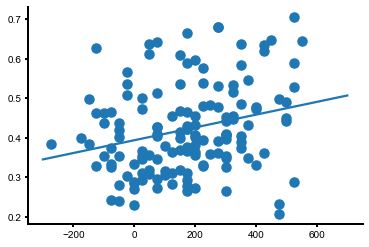

In [78]:
plt.scatter(X, y)
plt.plot(np.linspace(-300,700,100),reg_lin.T)

In [105]:
exp_type = 'CropInputs_SpdPup'
# MulW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveW'] for da in range(len(pparams['dates_all']))])
# AddW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_moveW'] for da in range(len(pparams['dates_all']))])


## SpeedPup Comparisons

In [30]:
exp_type = 'CropInputs_SpdPup'
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_r2_test'] for da in range(len(pparams['dates_all']))])

AddW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_moveW'] for da in range(len(pparams['dates_all']))])
MulW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveW'] for da in range(len(pparams['dates_all']))])
MotW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_moveW'] for da in range(len(pparams['dates_all']))])

Mot_thresh = vals_Mot>.05
vals_Add2 = (np.abs(AddW)/np.sum(np.abs(AddW),axis=1,keepdims=True))[Mot_thresh]
vals_Mul2 = (np.abs(MulW)/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_Mot2 = (np.abs(MotW)/np.sum(np.abs(MotW),axis=1,keepdims=True))[Mot_thresh]

np.nanmean(vals_Add2,axis=0),np.nanmean(vals_Mul2,axis=0),np.nanmean(vals_Mot2,axis=0)

(array([0.08929808, 0.06503979, 0.10097475, 0.06657274, 0.48181292,
        0.19630174], dtype=float32),
 array([0.13502494, 0.10271069, 0.1625755 , 0.10584073, 0.37454358,
        0.11930456], dtype=float32),
 array([0.06093238, 0.04398612, 0.07875887, 0.05633029, 0.44754237,
        0.31245   ], dtype=float32))

In [31]:
vals_nonVis = (np.sum(np.abs(MulW)[:,:4],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_nonVis2 = (np.sum(np.abs(MulW)[:,4:5],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_nonVis3 = (np.sum(np.abs(MulW)[:,5:],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]

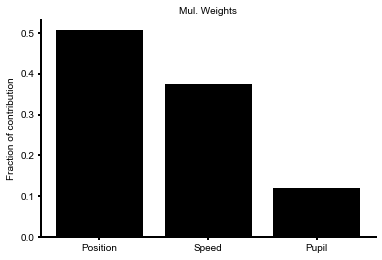

In [35]:
fig, axs = plt.subplots()
axs.bar([0], np.nanmean(vals_nonVis,axis=0), color='k')
axs.bar([1], np.nanmean(vals_nonVis2,axis=0), color='k')
axs.bar([2], np.nanmean(vals_nonVis3,axis=0), color='k')
axs.set_xticks(np.arange(0,3))
axs.set_xticklabels(['Position','Speed','Pupil'],fontsize=fontsize)
axs.set_ylabel('Fraction of contribution',fontsize=fontsize)
axs.set_title('Mul. Weights',fontsize=fontsize)
fig.savefig(paper_fig_dir/'Mul_SpdPup_Contribution.pdf', dpi=300, transparent=True, bbox_inches='tight')


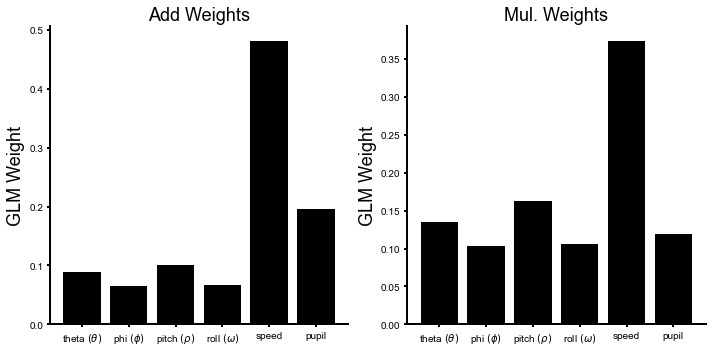

In [36]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$','speed','pupil']
move_clrs = ['blue','orange','green','red','magenta','black'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]

fig, axs = plt.subplots(1,2,figsize=(10,5))
for modeln in range(len(titles)):
    axs[0].bar(modeln, np.nanmean(vals_Add2,axis=0)[modeln], color='k')
    axs[0].set_xticks(np.arange(0,len(titles)))
    axs[0].set_xticklabels(titles)
    axs[0].set_ylabel('GLM Weight')
    axs[0].set_title('Add Weights')

    axs[1].bar(modeln, np.nanmean(vals_Mul2,axis=0)[modeln], color='k')
    axs[1].set_xticks(np.arange(0,len(titles)))
    axs[1].set_xticklabels(titles)
    axs[1].set_ylabel('GLM Weight')
    axs[1].set_title('Mul. Weights')
plt.tight_layout()


In [ ]:
# mult weight bar plot. with bar plot of fits with visual, mult pos, mult only speedpup. mult all. 

Text(0.5, 0.98, 'vis_cc: 0.438, add_cc: 0.518, mul_cc: 0.578')

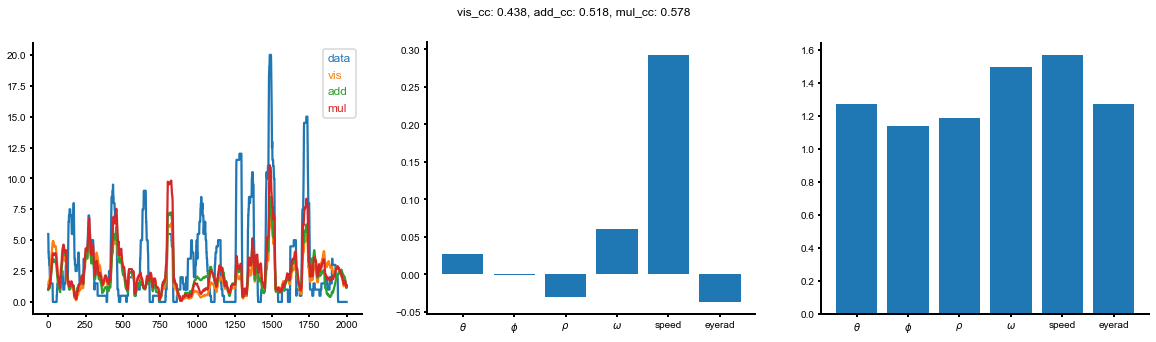

In [71]:
exp_type = 'CropInputs_SpdPup'
t = 0
dt = int(100/params['model_dt'])
# dt = 1000
cell = 265 # np.nanargmax(GLM_Data['cc_test'])
CellNum_Tot = get_cellnums(All_data,pparams,exp_type=exp_type)
da,celln = ([[da,np.where(CellNum_Tot[key]==cell)[0][0]] for da,key in enumerate(CellNum_Tot.keys()) if len(np.where(CellNum_Tot[key]==cell)[0])>0])[0]

titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$','speed','eyerad']
fig, axs = plt.subplots(1,3,figsize=(20,5))
ax = axs[0]
ax.plot(All_data[pparams['date_ani2'][da]]['actual_smooth'][t:t+dt,celln],label='data')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Vis_pred_smooth'][t:t+dt,celln],label='vis')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Add_pred_smooth'][t:t+dt,celln],label='add')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Mul_pred_smooth'][t:t+dt,celln],label='mul')
ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,)

ax = axs[1]
ax.bar(titles,All_data[pparams['date_ani2'][da]][exp_type]['Add_moveW'][celln]+All_data[pparams['date_ani2'][da]][exp_type]['Add_moveBias'][celln])

ax = axs[2]
ax.bar(titles,All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveW'][celln]+All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveBias'][celln])

plt.suptitle('vis_cc: {:.03f}, add_cc: {:.03f}, mul_cc: {:.03f}'.format(All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'][celln],All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'][celln],All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'][celln]))



## Tuning half/half

In [20]:
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    tuning_thresh = .2
    thresh_fr = 1
    spk_percentile2 = np.arange(.125,1.125,.25)
    quartiles = np.arange(0,1.25,.25)

    nsp_half0 = data['model_nsp'][:data['model_nsp'].shape[0]//2]
    tuning_curves0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],1))
    tuning_curve_edges0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims0 = np.zeros((nsp_half0.shape[-1],model_move.shape[-1]))

    nsp_half1 = data['model_nsp'][data['model_nsp'].shape[0]//2:]
    tuning_curves1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],1))
    tuning_curve_edges1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims1 = np.zeros((nsp_half1.shape[-1],model_move.shape[-1]))
    for i,modeln in enumerate(range(model_move.shape[-1])):
        for celln in np.arange(nsp_half0.shape[1]):
            metric0 = model_move[:data['model_nsp'].shape[0]//2,modeln]
            nranges0 = np.quantile(metric0,quartiles)
            stat_range0, edges0, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='mean',bins=nranges0)
            stat_std0, _, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='std',bins=nranges0)
            tuning_curves0[celln,modeln] = stat_range0/params['model_dt']
            edge_mids0 = np.quantile(metric0,spk_percentile2)
            tuning_curve_edges0[celln,modeln] = edge_mids0
            tuning_stds0[celln,modeln] = stat_std0.max()

            metric1 = model_move[data['model_nsp'].shape[0]//2:,modeln]
            nranges1 = np.quantile(metric1,quartiles)
            stat_range1, edges1, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='mean',bins=nranges1)
            stat_std1, _, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='std',bins=nranges1)
            tuning_curves1[celln,modeln] = stat_range1/params['model_dt']
            edge_mids1 = np.quantile(metric1,spk_percentile2)
            tuning_curve_edges1[celln,modeln] = edge_mids1
            tuning_stds1[celln,modeln] = stat_std1.max()
        ax_ylims0[:,modeln] = np.nanmax(tuning_curves0[:,modeln],axis=-1)
        ax_ylims1[:,modeln] = np.nanmax(tuning_curves1[:,modeln],axis=-1)
    tc_mod0 = (np.max(tuning_curves0,axis=-1,keepdims=True)-np.min(tuning_curves0,axis=-1,keepdims=True))/(np.max(tuning_curves0,axis=-1,keepdims=True)+np.min(tuning_curves0,axis=-1,keepdims=True))
    avg_fr0 = np.mean(tuning_curves0,axis=(-1,-2)).squeeze()
    tc_mod1 = (np.max(tuning_curves1,axis=-1,keepdims=True)-np.min(tuning_curves1,axis=-1,keepdims=True))/(np.max(tuning_curves1,axis=-1,keepdims=True)+np.min(tuning_curves1,axis=-1,keepdims=True))
    avg_fr1 = np.mean(tuning_curves1,axis=(-1,-2)).squeeze()

    tuning_sig0 = tc_mod.copy()
    tuning_sig0[avg_fr0<thresh_fr,:,0] = np.nan
    tuning_sig20 = np.any(tuning_sig0>tuning_thresh,axis=1).squeeze()
    tuning_idx0 = np.where(tuning_sig20)[0]
    tuning_sig1 = tc_mod1.copy()
    tuning_sig1[avg_fr1<thresh_fr,:,0] = np.nan
    tuning_sig21 = np.any(tuning_sig1>tuning_thresh,axis=1).squeeze()
    tuning_idx1 = np.where(tuning_sig21)[0]
    tuning_sig = np.concatenate((tuning_sig0,tuning_sig1),axis=2)

    tuning_sig_all.append(tuning_sig)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=0)

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)


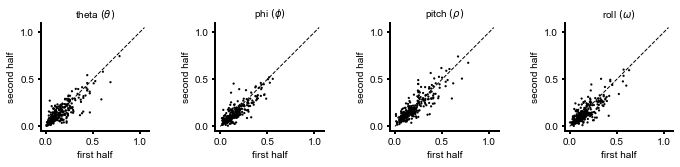

In [22]:
fig, axs = plt.subplots(1,4,figsize=(12,2))
for modeln in range(len(titles)):
    ax = axs[modeln]
    ax.scatter(tuning_sig_all[:,modeln,0],tuning_sig_all[:,modeln,1],s=5,c='k',edgecolors='none')
    ax.plot(np.linspace(0,1.05,100),np.linspace(0,1.05,100),c='k',lw=1,ls='--')
    ax.set_xticks([0,.5,1])
    ax.set_yticks([0,.5,1])
    ax.set_xlabel('first half',fontsize=fontsize)
    ax.set_ylabel('second half',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)
    ax.axis('square')
fig.savefig(paper_fig_dir/'5050_EyeHeadTuning.pdf', dpi=300, transparent=True, bbox_inches='tight')


## % stats 

In [83]:
from scipy.stats import ttest_rel

### % time active

In [13]:
da = 0
args['free_move']=True
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (128,)


In [14]:
print('% time active: {}'.format(np.sum(data['model_active']>.5)/data['model_active'].shape[0]))

% time active: 0.8049269602973103


Paired T test for Shifter on vs off

In [134]:
#### across all cells
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_VisNoSh = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test'] for da in range(len(pparams['dates_all']))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))
vis_th = r2_all[1] > .05
ttest_rel(r2_all[0,vis_th],r2_all[1,vis_th])

Ttest_relResult(statistic=-10.876786712591619, pvalue=8.169473254112951e-23)

In [136]:
#### Average within session then t-test across sessions
vals_Vis=[]
vals_VisNoSh=[]
for da in range(len(pparams['dates_all'])):
    vals_Vis.append(np.nanmean(All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test']))
    vals_VisNoSh.append(np.nanmean(All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test']))

vals_Vis=np.array(vals_Vis)
vals_VisNoSh=np.array(vals_VisNoSh)

ttest_rel(vals_Vis,vals_VisNoSh)

Ttest_relResult(statistic=9.569789871652118, pvalue=0.0024207492907047288)

### Standard Deviation of positional information

In [ ]:

np.round(np.nanstd(model_move_FM,axis=0),decimals=1),np.round(np.nanstd(model_move_HF,axis=0),decimals=1)

(array([15.3, 16.2, 21.8, 16.7]), array([10. , 11.1,  0. ,  0. ]))

In [ ]:
np.sum(np.abs(model_move_FM[:,0])<15)/(model_move_FM.shape[0])

0.6717352415026834

### number of units increased with joint fit

In [137]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])

np.sum(vals_Mot>vals_Vis),vals_Vis.shape[0],np.sum(vals_Mot<vals_Vis),vals_Vis.shape[0]

(88, 268, 180, 268)

In [138]:
np.mean(vals_Vis[vals_Vis>.05]), np.nanmean(vals_Vis), np.nanmax(vals_Vis)

(0.2987052372731739, 0.2793893241134035, 0.6929497920240357)

In [139]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
move_r2_th = (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]

In [140]:
vals_joint = np.stack((vals_Add,vals_Mul))
vals_increased = np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]
# np.mean(vals_increased)
np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]

array([1.60237023e-01, 2.10759292e-01, 8.44310839e-02, 9.16804615e-02,
       1.28332874e-02, 8.55281144e-02, 7.49617930e-02, 1.16576069e-02,
       4.54807161e-03, 1.90276380e-02, 6.86588678e-02, 2.74539790e-02,
       6.35846597e-02, 7.34170167e-02, 6.48618962e-02, 2.76010368e-02,
       5.32900734e-02, 7.21064648e-02, 1.39295553e-02, 1.94519727e-01,
       1.17571696e-01, 4.22013780e-03, 6.31746605e-02, 7.85617991e-02,
       2.30059865e-02, 8.71331774e-02, 5.21654505e-03, 3.68643118e-02,
       1.17921693e-01, 7.61320530e-02, 1.27140003e-03, 5.25873701e-02,
       8.18700924e-02, 3.50738434e-02, 9.35545101e-02, 7.75158148e-02,
       2.12717059e-02, 1.83385220e-02, 6.23071717e-02, 2.68118155e-02,
       2.35910913e-02, 1.68114226e-01, 1.84078832e-02, 2.94479017e-03,
       2.67113488e-02, 5.43755310e-02, 9.67029664e-02, 9.35350457e-03,
       1.03441323e-01, 1.86063721e-02, 8.31729881e-02, 1.13616254e-01,
       1.21856868e-02, 7.08692895e-02, 1.99920562e-01, 5.35724481e-02,
      

T-test: Add vs Mul

In [141]:
from scipy.stats import ttest_1samp

In [90]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
increase = vals_Vis
th1 = ((increase>0) & (vals_Vis>.22))

In [91]:
ttest_rel(vals_Mul[th1],vals_Add[th1])

Ttest_relResult(statistic=2.348124896626806, pvalue=0.020238242890030563)

In [ ]:
## Paired t-test between mul and add and show the distributions are different. 

In [145]:
avg_diff = []
avg_add=[]
avg_mul=[]
for da in range(len(pparams['dates_all'])):
    vM = All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test']
    vV = All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test']
    vA = All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test']
    v_th = ((vA>vV) | (vM>vV)) & (vV>.05) # & (vals_Mul>vals_Vis)
    diff = vM[v_th]-vA[v_th]
    avg_add.append(np.nanmean(vA[v_th]))
    avg_mul.append(np.nanmean(vM[v_th]))
    avg_diff.append(np.nanmean(diff))
    print(np.nanmean(diff))
ttest_1samp(avg_diff,popmean=0)

0.0011243180542266646
0.0034261237095284548
0.0013546811281835317
0.001979973431633001


Ttest_1sampResult(statistic=3.808923352709135, pvalue=0.031811240809062516)

In [147]:
ttest_rel(vals_Add,vals_Mul),ttest_rel(avg_add,avg_mul)

(Ttest_relResult(statistic=-1.701708742519062, pvalue=0.090387573442432),
 Ttest_relResult(statistic=-3.8089233527090736, pvalue=0.03181124080906383))

In [148]:
np.argmax(vals_Add[vals_Add<vals_Mul]),vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])]

(10, 0.703694253519955)

In [149]:
np.nanargmax(vals_Add-vals_Mul),vals_Add[92],vals_Mul[92]

(15, 0.35288682542226124, 0.3335608004999366)

In [150]:
np.where(vals_Add==vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])])

(array([18]),)

# 5050 splits

In [5]:
from sklearn.metrics import r2_score

args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
ModelList_5050 = []
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT', '020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
for date_ani in dates_all:
    for is_fm in [False,True]:
        args['free_move'] = is_fm
        if args['free_move']:
            stim_type = 'fm1'
        else:
            stim_type = 'hf1_wn'  # 'fm1' #

        args['save_dir']         = '~/Research/SensoryMotorPred_Data/data4/'
        args['date_ani']         = date_ani
        args['train_shifter']    = False
        args['NoL1']             = False
        args['NoL2']             = False
        args['reg_lap']          = False
        args['complex']          = False
        args['do_shuffle']       = False
        args['shifter_5050']     = True
        args['shifter_5050_run'] = False
        args['Nepochs']          = 10000


        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        if args['train_shifter']:
            params['lag_list']     = [0]
            params['nt_glm_lag']   = len(params['lag_list'])
            params['Nepochs']      = 5000
        data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best.h5'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        ModelList = sorted(list(exp.save_dir.rglob(mod_name)))
        model_info = params['date_ani2']+'_'+mod_name.replace('*', '')
        ModelList_5050.append(ModelList)
##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, complex: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))
ModelList_5050 = np.stack(ModelList_5050).reshape(4,4)


Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)
Model: 1, LinMix: False, move_features: None, Ncells: 52, train_shifter: False, NoL1: False, NoL2: False, reg_lap: False, complex: False


In [51]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
split_5050 = {date_ani2[n]:{'5050split':{}} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    GLM_Data0_HF = ioh5.load(ModelList_5050[da,0])
    GLM_Data1_HF = ioh5.load(ModelList_5050[da,1])
    GLM_Data0_FM = ioh5.load(ModelList_5050[da,2])
    GLM_Data1_FM = ioh5.load(ModelList_5050[da,3])
    RF0_HF = GLM_Data0_HF['Cell_NN.0.weight'].reshape((GLM_Data0_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF1_HF = GLM_Data1_HF['Cell_NN.0.weight'].reshape((GLM_Data1_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF0_FM = GLM_Data0_FM['Cell_NN.0.weight'].reshape((GLM_Data0_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF1_FM = GLM_Data1_FM['Cell_NN.0.weight'].reshape((GLM_Data1_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_all_up0 = np.zeros(((2,) + RF0_HF.shape[:2] + ( sf*(RF0_HF.shape[-2]), sf*(RF0_HF.shape[-1]))))
    RF_all_up1 = np.zeros(((2,) + RF1_HF.shape[:2] + ( sf*(RF1_HF.shape[-2]), sf*(RF1_HF.shape[-1]))))

    for celln in range(RF0_HF.shape[0]):
        for t in range(RF0_HF.shape[1]):
            RF_all_up0[0,celln,t] = cv2.resize(RF0_HF[celln,t], (sf*(RF0_HF.shape[-1]), sf*(RF0_HF.shape[-2])))
            RF_all_up1[0,celln,t] = cv2.resize(RF1_HF[celln,t], (sf*(RF1_HF.shape[-1]), sf*(RF1_HF.shape[-2])))
            RF_all_up0[1,celln,t] = cv2.resize(RF0_FM[celln,t], (sf*(RF0_FM.shape[-1]), sf*(RF0_FM.shape[-2])))
            RF_all_up1[1,celln,t] = cv2.resize(RF1_FM[celln,t], (sf*(RF1_FM.shape[-1]), sf*(RF1_FM.shape[-2])))
    RF_CC_HF = np.zeros(RF0_HF.shape[0])
    RF_CC_FM = np.zeros(RF0_HF.shape[0])
    for celln in np.arange(RF0_HF.shape[0]):
        RF_CC_HF[celln] = np.corrcoef(RF0_HF[celln,2].flatten(),RF1_HF[celln,2].flatten())[0,1]
        RF_CC_FM[celln] = np.corrcoef(RF0_FM[celln,2].flatten(),RF1_FM[celln,2].flatten())[0,1]
    split_5050[date_ani]['5050split']['RF0_HF'] = RF0_HF
    split_5050[date_ani]['5050split']['RF1_HF'] = RF1_HF
    split_5050[date_ani]['5050split']['RF0_FM'] = RF0_FM
    split_5050[date_ani]['5050split']['RF1_FM'] = RF1_FM
    split_5050[date_ani]['5050split']['RF_all_up0'] = RF_all_up0
    split_5050[date_ani]['5050split']['RF_all_up1'] = RF_all_up1
    split_5050[date_ani]['5050split']['RF_CC_HF'] = RF_CC_HF
    split_5050[date_ani]['5050split']['RF_CC_FM'] = RF_CC_FM

In [52]:
exp_type = '5050split'
RF_CC_HF_all = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_all_up0 = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up0'] for da in range(len(dates_all))],axis=1)
RF_all_up1 = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up1'] for da in range(len(dates_all))],axis=1)
 

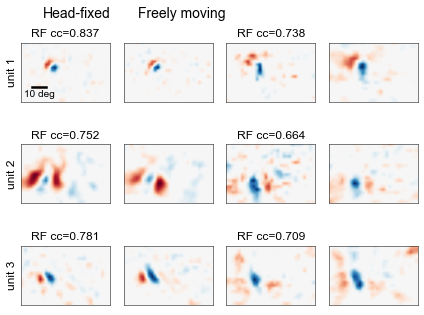

In [57]:
fontsize=12
lag_list = [0,0] #params['lag_list']
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [22,101,61]#[22,42,101] 

fig1,axs = plt.subplots(len(cells),2*len(lag_list),figsize=(len(cells)*len(lag_list),1.5*len(cells)))
axs = axs.reshape(len(cells),2*len(lag_list))

for n, cell in enumerate(cells):
    for m,lag in enumerate(lag_list):
        if m == 0:
            crange0_HF = np.max(np.abs(RF_all_up0[0,cell,2]))
            crange0_FM = np.max(np.abs(RF_all_up0[1,cell,2]))
            ax = axs[n,m]
            im = ax.imshow(RF_all_up0[0,cell,2],'RdBu_r',vmin=-crange0_HF,vmax=crange0_HF)
            ax.set_title('RF cc={:.03f}'.format(RF_CC_HF_all[cell]),fontsize=fontsize)
            ax = axs[n,m+2]
            im = ax.imshow(RF_all_up0[1,cell,2],'RdBu_r',vmin=-crange0_FM,vmax=crange0_FM)
            ax.set_title('RF cc={:.03f}'.format(RF_CC_FM_all[cell]),fontsize=fontsize)
        else:
            crange1_HF = np.max(np.abs(RF_all_up1[0,cell,2]))
            crange1_FM = np.max(np.abs(RF_all_up1[1,cell,2]))
            ax = axs[n,m]
            im = ax.imshow(RF_all_up1[0,cell,2],'RdBu_r',vmin=-crange1_HF,vmax=crange1_HF)
            ax = axs[n,m+2]
            im = ax.imshow(RF_all_up1[1,cell,2],'RdBu_r',vmin=-crange1_FM,vmax=crange1_FM)
        # add_colorbar(im)
    axs[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)
scalebar = AnchoredSizeBar(axs[0,0].transData,
                        20, '10 deg', 'lower left', 
                        pad=0.1,
                        color='black',
                        frameon=False,
                        size_vertical=1,
                        )
axs[0,0].add_artist(scalebar)
# scale1 = ScaleBar(dx=.5, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} deg')
# axs[0,0].add_artist(scale1)

ext = []
for m in range(axs.shape[1]):
    ext.append([axs[0,m].get_window_extent().x0, axs[0,m].get_window_extent().width])

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
# axs[0,0].set_title('First half',fontsize=fontsize+2)
# axs[0,1].set_title('Second half',fontsize=fontsize+2)
inv = fig.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(left_center[0],.99,'Head-fixed', va="center", ha="center", size=fontsize+2)
plt.figtext(right_center[0],.99,'Freely moving', va="center", ha="center", size=fontsize+2)

# plt.text(x=.2,y=1.2,s='Head-fixed',transform=fig.transFigure,fontsize=fontsize)
plt.tight_layout()
# fig1.savefig(paper_fig_dir/('5050_RF_Comparison.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [54]:
width_left,left_center,width_right,right_center

(134.0608695652174,
 array([0.18619565, 0.00694444]),
 308.7391304347827,
 array([0.42880435, 0.00694444]))

In [58]:
ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.

[[54.0, 72.78260869565219],
 [141.33913043478265, 72.78260869565216],
 [228.67826086956526, 72.78260869565216],
 [316.0173913043478, 72.78260869565224]]

126

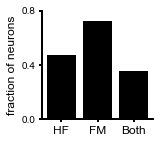

In [68]:
thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)))/RF_CC_HF_all.shape[0]

fig, axs = plt.subplots(figsize=(2,2))
ax = axs
ax.bar([0,1,2], [frac_HF, frac_FM, frac_both],color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['HF', 'FM', 'Both'],fontsize=fontsize)
ax.set_ylabel('fraction of neurons',fontsize=fontsize)
ax.set_yticks(np.arange(0,.81,.4))

fig1.savefig(paper_fig_dir/('fraction_significant.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [80]:
frac_both

0.3582089552238806

In [1]:
plt.hist(RF_CC_HF_all.flatten(),bins=20,c='k',alpha=.75)
plt.hist(RF_CC_FM_all.flatten(),bins=20,c='r',alpha=.75)


NameError: name 'plt' is not defined

# Complex RFs

In [47]:
pdf_name = paper_fig_dir/ ('ComplexRFs.pdf')
exp_type = 'complex'
FM_RF_all = np.concatenate([All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_all']  for da in range(len(pparams['dates_all']))],axis=0)
HF_RF_all = np.concatenate([All_data[pparams['date_ani2'][da]][exp_type]['HF_rf_all']  for da in range(len(pparams['dates_all']))],axis=0)
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_HF = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['HF_cc_test'] for da in range(len(pparams['dates_all']))])
# cell = 101
lag_list = 2*[-100,-50,0,50,100]
pdf = PdfPages(pdf_name)
for n, cell in enumerate(tqdm(range(FM_RF_all.shape[0]))):
    fig, axs = plt.subplots(2,FM_RF_all.shape[1],figsize=(2*params['nt_glm_lag'],2))
    for m in range(2*params['nt_glm_lag']):
        crange2 = np.max(np.abs(FM_RF_all[cell])) 
        ax = axs[0,m]
        im2 = ax.imshow(FM_RF_all[cell, m],'RdBu_r', vmin=-crange2, vmax=crange2)
        ax.set_title('{} ms'.format(lag_list[m]),fontsize=fontsize)
        crange1 = np.max(np.abs(HF_RF_all[cell])) 
        ax = axs[1,m]
        im1 = ax.imshow(HF_RF_all[cell, m], 'RdBu_r', vmin=-crange1, vmax=crange1) 
        ax.set_title('{} ms'.format(lag_list[m]),fontsize=fontsize)
        if m == 9:
            cbar2 = add_colorbar(im2)
            cbar1 = add_colorbar(im1)
            cbar2.outline.set_linewidth(1)
            cbar1.outline.set_linewidth(1)


    plt.suptitle('unit: {} FMcc={:.03f} HFcc={:.03f} '.format(cell,vals_Vis[cell],vals_HF[cell]), fontsize=fontsize).set_multialignment('center')
    
    axs[1,0].set_ylabel('head- \n fixed', fontsize=fontsize)
    axs[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

    for ax in axs.flat:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.spines[axis].set_visible(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])   


    pdf.savefig()
    plt.close()

pdf.close()


  0%|          | 0/268 [00:00<?, ?it/s]

# Supplementary Figures

#### Shifter Matricies

In [ ]:
da = 0
fontsize=10
args['date_ani'] = dates_all[da]
params,_,_ = load_params(0,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'

save_datafile = save_dir_fm/'GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'
GLM_CV = ioh5.load(save_datafile)

best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))

##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_dir'] / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)


Done Loading Unaligned data
Tot_units: (128,)


/tmp/ipykernel_534275/3904998252.py:12: RuntimeWarning: Mean of empty slice
  best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))


/tmp/ipykernel_534275/2073312972.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


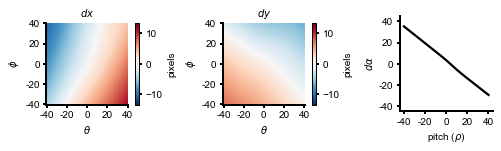

In [ ]:
fontsize = 10

fig = plt.figure(constrained_layout=False, figsize=(8,5))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.9,hspace=0)
# gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,:3], wspace=.1,hspace=0)
# gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,3:6], wspace=.1,hspace=.1)
# gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,6:], wspace=.1,hspace=.1)

# gs01a = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.2)
# gs02a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)
# gs03a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0[0,0])])#,fig.add_subplot(gs01[0,0]),fig.add_subplot(gs01[1,1])])
axs2a = np.array([fig.add_subplot(gs0[0,1])])#,fig.add_subplot(gs02[1,0]),fig.add_subplot(gs02[1,1])])
axs3a = np.array([fig.add_subplot(gs0[0,2])])#,fig.add_subplot(gs03[1,0]),fig.add_subplot(gs03[1,1])])



shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
# for n in range(2):
ax = axs1a[0]
n=0
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs2a[0]
n = 1
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs3a[0]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'pitch ($\rho$)',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.axis('square')
ax.set_ylim(-45, 45)


plt.tight_layout()
fig.savefig(paper_fig_dir/'FigureS1.pdf', facecolor='white', transparent=True, bbox_inches='tight')


#### SimRF 

In [ ]:
# SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
# SimRF_GLM_file = '/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
# GLM_Data = ioh5.load(SimRF_GLM_file)
# SimRF_data = ioh5.load(SimRF_file)
# RF_Sim = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0], 1,)+(30,40))
# Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
# Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_data['yte'].copy())[params['bin_length']:-params['bin_length']].T
# Sim_r2 = np.array([(np.corrcoef(Sim_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])


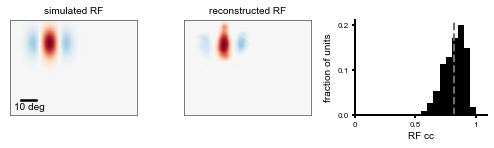

In [27]:
fig,axs = plt.subplots(1,3,figsize=(7,2))
lag = 1
da = 0
sf=4
cells = [0]
for n, cell in enumerate(cells):
    ax = axs[n]
    crange2 = np.max(np.abs(All_data['SimData']['Simact_RF'][cell]))
    RF_Simact_up = cv2.resize(All_data['SimData']['Simact_RF'][cell], (sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-2])))
    im2 = ax.imshow(RF_Simact_up,'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('simulated RF', fontsize=fontsize)
    ax = axs[n+1]
    crange1 = np.max(np.abs(All_data['SimData']['Simfit_RF'][cell]))
    RF_Simfit_up = cv2.resize(All_data['SimData']['Simfit_RF'][cell,0], (sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-2])))
    im2 = ax.imshow(RF_Simfit_up,'RdBu_r', vmin=-crange1, vmax=crange1)
    ax.set_title('reconstructed RF', fontsize=fontsize)
scalebar = AnchoredSizeBar(axs[0].transData,
                    20, '10 deg', 'lower left', 
                    pad=0.1,
                    color='black',
                    frameon=False,
                    size_vertical=1,
                    )
axs[0].add_artist(scalebar)  

for ax in axs.flat[:-1]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2G ########## 
# gs05 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2,6:],wspace=.1,hspace=.1)
# axs5 = np.array([fig1.add_subplot(gs05[0,0])])
ax=axs[2]
hbins = .05
lim0 = .2
lim1 = 1.1
dlim = .5
xlab = 'RF cc'
simfr_mean = np.mean(All_data['SimData']['Sim_yte'],axis=0)/params['model_dt']
simfr_low = All_data['SimData']['Sim_cc'][2::3] #Sim_r2[((simfr_mean<5))]
simfr_med = All_data['SimData']['Sim_cc'][1::3] #Sim_r2[((simfr_mean>5) & (simfr_mean<10))]
simfr_high = All_data['SimData']['Sim_cc'][0::3] #Sim_r2[((simfr_mean>10))]

mean_fr_low = np.nanmean(simfr_mean[2::3])
mean_fr_med = np.nanmean(simfr_mean[1::3])
mean_fr_high = np.nanmean(simfr_mean[0::3])

count,edges = np.histogram(simfr_med,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_med),color='k',width=hbins, alpha=1,label='high FR')

ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,.5,1],fontsize=fontsize-2)
ax.set_xlabel('cc')
# ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper left',ncol=1)#, bbox_to_anchor=(.1, .9))

ax.set_yticks(np.linspace(0,np.round(np.max(count/len(simfr_med)),1),3))
ax.set_yticklabels(np.linspace(0,np.round(np.max(count/len(simfr_med)),1),3),fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(simfr_med),lw=2,c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
plt.tight_layout()
fig.savefig(paper_fig_dir/'SimRF.pdf', ppi=300, transparent=True, bbox_inches='tight')


Text(0, 0.5, 'sp/sec')

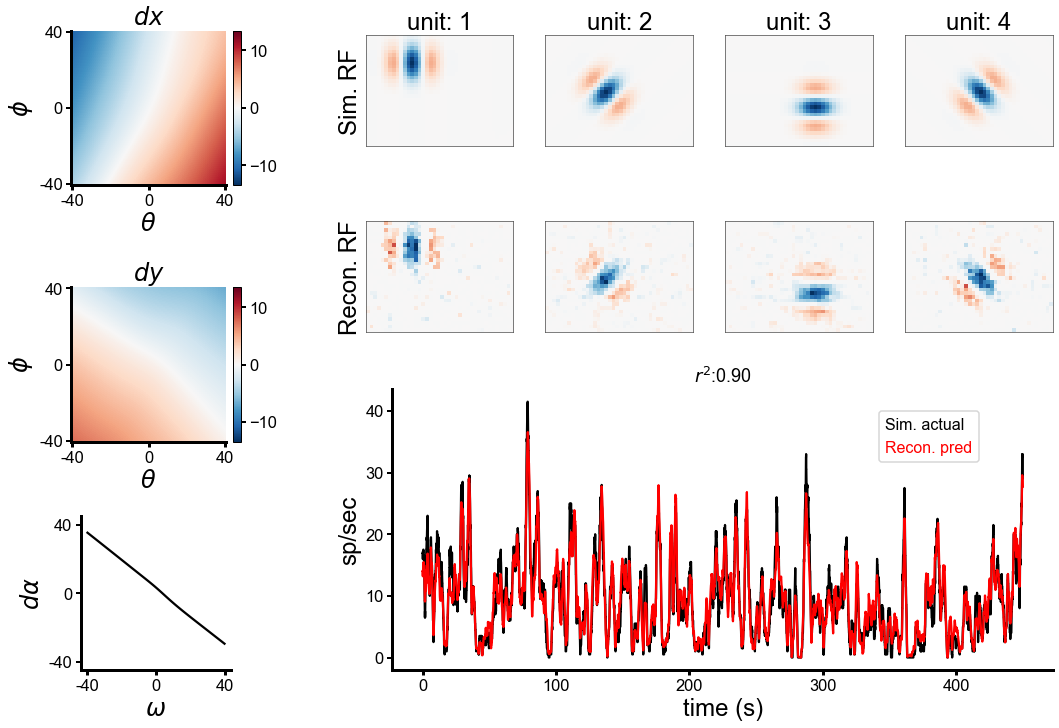

In [ ]:
fig1 = plt.figure(constrained_layout=True, figsize=(15,10))
gs0 = fig1.add_gridspec(nrows=2, ncols=3, wspace=.6, hspace=.2)

gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,0],wspace=1,hspace=.1)
axs1 = np.array([fig1.add_subplot(gs01[n,m]) for n in range(3) for m in range(1)]).reshape(3)

shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,40)
ticklabels=np.arange(-40,50,40)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(2):
    ax = axs1[n]
    im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    cbar1.outline.set_linewidth(1)
    # cbar1.set_label(cbar_label[n],fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\theta$',fontsize=fontsize)
    ax.set_ylabel(r'$\phi$',fontsize=fontsize)
    ax.set_title(shift_titles[n],fontsize=fontsize)
ax = axs1[2]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'$\omega$',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,0,40])
ax.set_yticklabels([-40,0,40])
ax.axis('square')
ax.set_ylim(-45, 45)


cells = [0,25,62,43]
gs02 = gridspec.GridSpecFromSubplotSpec(2, len(cells), subplot_spec=gs0[:1,1:],wspace=.1,hspace=.05)
axs2 = np.array([fig1.add_subplot(gs02[n,m]) for n in range(2) for m in range(len(cells))]).reshape(2,len(cells))
for n, cell in enumerate(cells):
    ax = axs2[0,n]
    crange2 = np.max(np.abs(SimRF_data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax = axs2[1,n]
    crange1 = np.max(np.abs(RF_Sim[cell]))
    im2 = ax.imshow(RF_Sim[cell,0],'RdBu_r', vmin=-crange1, vmax=crange1)


    # crange2 = np.max(np.abs(RF_all[0,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im2 = axs1[0,n].imshow(RF_all[0,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    # crange1 = np.max(np.abs(RF_all[1,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im1 = axs1[1,n].imshow(RF_all[1,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs2[0,n].set_title('unit: {}'.format(n+1), fontsize=fontsize)

axs2[1,0].set_ylabel('Recon. RF', fontsize=fontsize)
axs2[0,0].set_ylabel('Sim. RF', fontsize=fontsize)
for ax in axs2.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   
# cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange1, crange1])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)


gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,1:],wspace=.1,hspace=.1)
axs3 = np.array([fig1.add_subplot(gs03[0,:])])

cell = 62
ax = axs3[0]
pred_time = (np.arange(Sim_act_smooth.shape[1])*params['model_dt'])
ax.plot(pred_time,Sim_act_smooth[cell],c='k', label='Sim. actual')
ax.plot(pred_time,Sim_smooth[:,cell],c='r', label='Recon. pred')
ax.legend(labelcolor='linecolor', fontsize=16, handlelength=0, handletextpad=0,loc='upper right',ncol=1, bbox_to_anchor=(.9, .95))
ax.set_title('$r^2$:{:.02f}'.format(Sim_r2[cell]))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

In [ ]:
#Histogram 
# Simulated shifter network data. 

### Figure S2

In [ ]:
da = 2
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (56,)


In [ ]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))


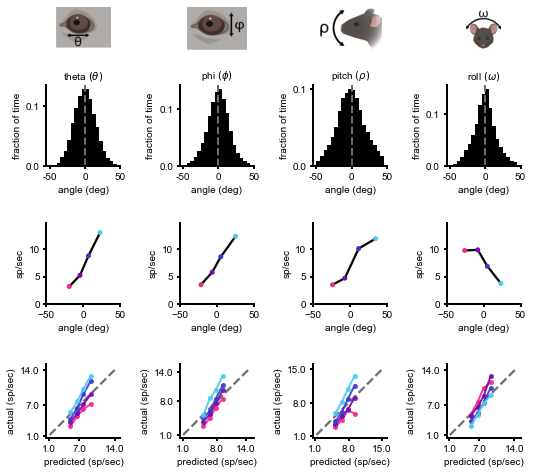

In [ ]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']

celln = 1#16 #106

modN = 0
anglim = 70
pparams['titles'] = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
pparams['anglim'] = 70
pparams['quartiles'] = np.arange(0,1.25,.25)
pparams['spike_percentiles'] = np.arange(0,1.25,.25)
pparams['spike_percentiles'][-1]=.99
pparams['spk_percentile2'] = np.arange(.125,1.125,.25)

ncells=All_data[pparams['date_ani2'][da]][exp_type]['Vis_pred_smooth'].shape[-1]
predcell = All_data[pparams['date_ani2'][da]][exp_type]['Vis_pred_smooth'][:,celln]
nspcell = All_data[pparams['date_ani2'][da]]['actual_smooth'][:,celln]
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,pparams['spike_percentiles'])
xbin_pts = np.quantile(predcell,pparams['spk_percentile2'])
stat_bins = len(pred_rangelin)
tuning_sig_all = np.vstack([All_data[pparams['date_ani2'][da]]['tuning_sig'].squeeze() for da in range(len(pparams['dates_all']))])
ax_ylims_all = np.vstack([All_data[pparams['date_ani2'][da]]['ax_lims'].squeeze() for da in range(len(pparams['dates_all']))])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))


fig = plt.figure(constrained_layout=False, figsize=(8.5,8))
gs0 = gridspec.GridSpec(ncols=4, nrows=6, figure=fig, wspace=.3, hspace=.8)

##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
gs00b = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=gs0[1:,:],wspace=.8,hspace=.7)
axs0aa = np.array([fig.add_subplot(gs00[0,m]) for m in range(4)])
axs0a = np.array([fig.add_subplot(gs00b[0,m]) for m in range(4)])
axs0b = np.array([fig.add_subplot(gs00b[1,m]) for m in range(4)])
axs0c = np.array([fig.add_subplot(gs00b[2,m]) for m in range(4)])

for modeln in np.arange(len(titles)):
    ax=axs0aa[modeln]
    ax.imshow(icons[modeln])
    ax.axis('off')


hbins=5
xticks = [-50, 0, 50]
yticks = [0,.1]
for modeln in np.arange(len(titles)):
    ax=axs0a[modeln]
    count,edges = np.histogram(model_move_FM[:,modeln],bins=np.arange(-50,50,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/(model_move_FM.shape[0]),color='k',width=hbins, alpha=1)
    ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
    ax.set_title(titles[modeln],fontsize=fontsize)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('fraction of time',fontsize=fontsize)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_yticks(yticks)


dwidth = .1
for modeln in np.arange(0,len(titles)):
    ax = axs0b[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
    stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

    edge_mids = np.quantile(metric,spk_percentile2)#
    # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
    ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=1,c='k',zorder=0,markeredgewidth=0)
    ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
    ax.set_xlim(-xlim_range,xlim_range)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('sp/sec',fontsize=fontsize)
    # ax.set_title(titles[modeln],fontsize=fontsize)
    # ax.axis('square')
    ax.set_ylim(0,top_yaxs)

for modeln in range(len(titles)):
    ax = axs0c[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
        ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
    # ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
    ax.set_xticks([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])]) #np.arange(lims[0],lims[1],int(lims[1]/2)))
    ax.set_yticks([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])]) #np.arange(lims[0],lims[1],int(lims[1]/2)))
    ax.set_xticklabels([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])])# np.round(np.arange(lims[0],lims[1],int(lims[1]/2))))
    ax.set_yticklabels([np.floor(lims[0]),np.floor(lims[0]+ (lims[1]-lims[0])/2),np.floor(lims[1])])# np.round(np.arange(lims[0],lims[1],int(lims[1]/2))))
    ax.axis('square')
    # ax.set(xlim=lims, ylim=lims)
    # ax.set_ylim(bottom=0)
    # ax.set_xlim(left=0)
fig.savefig(paper_fig_dir/'FigureS2.pdf', transparent=True, bbox_inches='tight')


In [ ]:
lim_max

14.572481194055733

## Darkness Data

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
args['fm_dark'] = False
if args['free_move']:
    stim_type = 'fm1'
elif args['fm_dark']:
    stim_type = 'fm1_dark'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['save_dir'] = '~/Research/SensoryMotorPred_Data/data2/'
args['date_ani'] = dates_all[0]
args['train_shifter']=True
args['NoL1'] = False
args['NoL2'] = False
args['complex'] = False
args['reg_lap'] = False
args['do_shuffle']=False
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

Done Loading Unaligned data
Tot_units: (26,)
Model: 1, LinMix: False, move_features: None, Ncells: 7, train_shifter: True, NoL1: True, NoL2: False, reg_lap: False, comples: False


In [ ]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all =  ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    tuning_sig1,tuning_sig2a,NCells1,bad_cells1,test_nsp1,model_move1= [], [], [], [], [], [],
    for fm_dark in [False,True]:
        args['date_ani']    = date_ani
        args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
        args['free_move']   = True
        args['fm_dark']     = fm_dark
        if args['free_move'] :
            if args['fm_dark']:
                stim_type   = 'fm1_dark'
            else:
                stim_type   = 'fm1'
        else:
            stim_type       = 'hf1_wn'
        args['NoL1']        = False
        args['NoL2']        = False
        args['reg_lap']     = False
        args['complex']     = False
        args['do_shuffle']  = False
        args['Nepochs']     = 10000
        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        params['nt_glm_lag']=5
        params['thresh_cells']=0
        date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        # ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('RevisionSims' in path.as_posix()) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
        # ModelList_all.append(ModelList)
        bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
        data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
        bad_cells1.append(bad_cells)
        # model_move1.append(model_move)
        tuning_sig1.append(tuning_sig)
        tuning_sig2a.append(tuning_sig2)
        print(stim_type,mod_name)
    bad_cells_all.append(np.stack(bad_cells1))
    # model_move_FM.append(np.stack(model_move1))
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(np.stack(tuning_sig1))
    tuning_sig_all2.append(np.stack(tuning_sig2a))
    NCells_all.append(len(tuning_sig2a))

# ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=1)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)

ModelList_all

Done Loading Unaligned data
fm1 *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1_dark *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1 *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1_dark *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1 *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1_dark *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1 *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1_dark *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1 *NoL1_dt050_T05*_NB10000_Kfold00_best
Done Loading Unaligned data
fm1_dark *NoL1_dt050_T05*_NB10000_Kfold00_best


[]

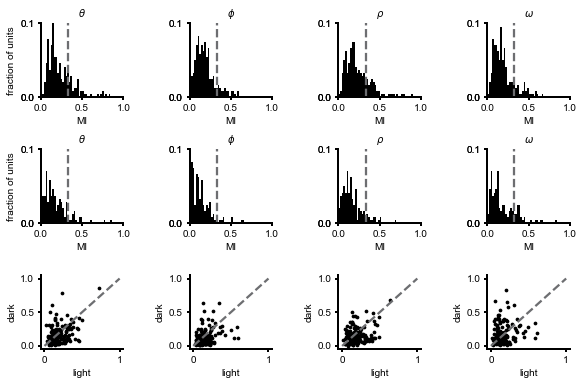

In [ ]:
##### Modulation Index Histograms #####
dwidth = .02
# fig,axs = plt.subplots(2,len(titles),figsize=(8,4))
fig = plt.figure(constrained_layout=False, figsize=(12,6))
gs0 = gridspec.GridSpec(nrows=1, ncols=5, figure=fig,wspace=.3,hspace=.8)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
# gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(3) for m in range(4) ]).reshape(3,4)
for dk in [0,1]:
    for modeln in np.arange(0,len(titles)):
        ax = axs1[dk,modeln]
        count,edges = np.histogram(tuning_sig_all[dk,:,modeln], bins=np.arange(0,1.1,dwidth))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(tuning_sig_all[dk,:,modeln]),color='k',width=dwidth,alpha=1)
        ax.axvline(x=.33,ls='--',color='#6D6E71')
        ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
        ax.set_xlabel('MI', fontsize=fontsize)
        # ax.set_ylabel('fraction of units', fontsize=fontsize)
        ax.set_xlim(0,1)
        ax.set_yticks(np.round(np.arange(0,.1,.02),decimals=1))
        ax.set_yticklabels(np.round(np.arange(0,.1,.02),decimals=1))
        ax.set_ylim(0,.1)
    axs1[dk,0].set_ylabel('fraction of units', fontsize=fontsize)

# for dk in [2]:
for modeln in np.arange(0,len(titles)):
    ax = axs1[2,modeln]
    ax.scatter(tuning_sig_all[0,:,modeln],tuning_sig_all[1,:,modeln],s=5,c='k')
    ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),ls='--',color='#6D6E71')
    ax.set_xlabel('light',fontsize=fontsize)
    ax.set_ylabel('dark',fontsize=fontsize)
    


plt.tight_layout()
fig.savefig(paper_fig_dir/('DarkTuning.pdf'), transparent=True, bbox_inches='tight',dpi=300)


## Video S1

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

# data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

# ##### Set Train Test Splits #####
# Kfold = 0
# train_idx = train_idx_list[Kfold]
# test_idx = test_idx_list[Kfold]
# data = load_Kfold_data(data,train_idx,test_idx,params)

data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [ ]:
data['model_vid_sm'].shape

(30272, 60, 80)

In [ ]:
date_ani = '070921/J553RT'
stim_type = 'fm1'
fmimu_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*imu.nc'))[0]
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*REYE.nc'))[0]
world_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*world.nc'))[0]
ephys_file = params['save_dir']/'RawEphysData.h5'

ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']

imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
eyeT = eye_data.timestamps  - ephys_data['t0'].iloc[0]

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

world_data = xr.open_dataset(file_dict['world'])
world_vid_raw = np.uint8(world_data['WORLD_video'])
worldT = world_data.timestamps.copy()
worldT = worldT - ephys_data['t0'].iloc[0]

if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
if worldT[0]<-600:
    worldT = worldT + 8*60*60
accT2 = accT.sample.data - ephys_data['t0'].iloc[0]

# isfast = np.diff(eyeT)<=0.05
# isslow = sorted(list(set(chain.from_iterable([list(range(int(i)-3,int(i)+4)) for i in np.where(isfast==False)[0]]))))
# th[isslow] = np.nan
# phi[isslow] = np.nan


In [ ]:
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).rglob('*REYEdeinter.avi'))[0]

cap = cv2.VideoCapture(eye_file.as_posix())
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = int(cap.get(cv2.CAP_PROP_FPS)) # float `fps`
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # float `total_frame_in_the_video` (should not be applicable for camera)
sf=2
eye_vid = np.zeros((int(total_frames),140, 175))
for t in tqdm(range(total_frames)):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray,(int(width//sf),int(height//sf)))
    eye_vid[t] = gray[100:,75:250]

cap.release()

  0%|          | 0/147790 [00:00<?, ?it/s]

In [ ]:

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

In [ ]:
worldT0

46

In [ ]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))

probe = image.imread(list(paper_fig_dir.glob('*probe.png'))[0])


(1497.0, 1513.0)

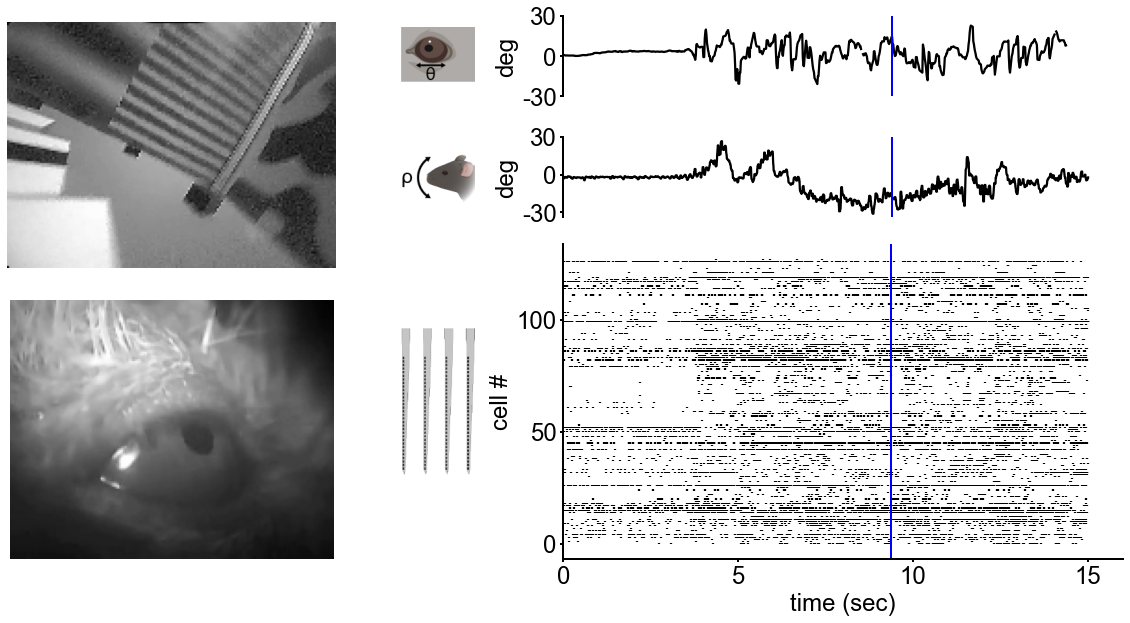

In [ ]:
dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])


wt=500
fontsize=24
t=worldTmin + wt
tt = worldT[t].data
eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
cell_t = np.nanargmin(np.abs(cellT-(tt)))

fig = plt.figure(constrained_layout=False, figsize=(20,10))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
axs1c = np.array([fig.add_subplot(gs02[0,1:])])

#### World/Eye Camera
ax = axs1a[0]
ax.imshow(world_vid_raw[t],cmap='gray')
ax.axis('off')
ax = axs1a[1]
ax.imshow(eye_vid[eye_interp_t],cmap='gray')
ax.axis('off')

##### Theta #####
ax = axs1bb[0]
ax.imshow(icons[0])
ax.axis('off')
ax = axs1b[0]
ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Phi #####
# ax = axs1bb[1]
# ax.imshow(icons[1])
# ax.axis('off')
# ax = axs1b[1]
# ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Pitch #####
ax = axs1bb[1]
ax.imshow(icons[2])
ax.axis('off')
ax = axs1b[1]
ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


##### Roll #####
# ax = axs1bb[3]
# ax.imshow(icons[3])
# ax.axis('off')
# ax = axs1b[3]
# ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

for ax, modeln in zip(axs1b,range(len(titles))):
    ax.set_yticks([-30,0,30])
    ax.set_yticklabels([-30,0,30], fontsize=fontsize)
    ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
    # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(Tmin,Tmax+1)


ax = axs1cc[0]
ax.imshow(probe)
ax.axis('off')
ax = axs1c[0]
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
ax.set_yticks([0,50,100])
ax.set_yticklabels([0,50,100], fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=cellT[cell_t],c='b',lw=2)
ax.set_xlim(Tmin,Tmax+1)

In [ ]:
@ray.remote
def make_plt_im(wt, worldTmin,worldTmax,worldT,eyeTmin,eyeTmax,eyeT,eye_vid,accT,moveTmin,moveTmax,world_vid_raw,th,phi,gpitch,groll,cell_spikes, Tmin,Tmax,dT,dT_all, pbar: ActorHandle,):  #
    t=worldTmin + wt
    tt = worldT[t].data
    eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
    acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
    cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
    cell_t = np.nanargmin(np.abs(cellT-(tt)))

    fig = plt.figure(constrained_layout=False, figsize=(20,10))
    gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
    gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
    gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

    gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

    axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
    axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
    axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
    axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
    axs1c = np.array([fig.add_subplot(gs02[0,1:])])

    #### World/Eye Camera
    ax = axs1a[0]
    ax.imshow(world_vid_raw[t],cmap='gray')
    ax.axis('off')
    ax = axs1a[1]
    ax.imshow(eye_vid[eye_interp_t],cmap='gray')
    ax.axis('off')

    ##### Theta #####
    ax = axs1bb[0]
    ax.imshow(icons[0])
    ax.axis('off')
    ax = axs1b[0]
    ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Phi #####
    # ax = axs1bb[1]
    # ax.imshow(icons[1])
    # ax.axis('off')
    # ax = axs1b[1]
    # ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Pitch #####
    ax = axs1bb[1]
    ax.imshow(icons[2])
    ax.axis('off')
    ax = axs1b[1]
    ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


    ##### Roll #####
    # ax = axs1bb[3]
    # ax.imshow(icons[3])
    # ax.axis('off')
    # ax = axs1b[3]
    # ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

    for ax, modeln in zip(axs1b,range(len(titles))):
        ax.set_yticks([-30,0,30])
        ax.set_yticklabels([-30,0,30], fontsize=fontsize)
        ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
        # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(Tmin,Tmax+1)


    ax = axs1cc[0]
    ax.imshow(probe)
    ax.axis('off')
    ax = axs1c[0]
    ax.eventplot(cell_spikes,color='k',linelengths=.5)
    ax.set_xlabel('time (sec)',fontsize=fontsize)
    ax.set_ylabel('cell #',fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
    ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels([0,50,100], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=cellT[cell_t],c='b',lw=2)
    ax.set_xlim(Tmin,Tmax+1)

    plt.show()
    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [ ]:
mpl.use('agg')

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(worldTmax-worldTmin)
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
worldT_r = ray.put(worldT.data)
eyeT_r = ray.put(eyeT)
accT_r = ray.put(accT)
world_vid_raw_r = ray.put(world_vid_raw)
th_r = ray.put(th)
phi_r = ray.put(phi)
gpitch_r = ray.put(gpitch)
groll_r = ray.put(groll)
cell_spikes_r = ray.put(cell_spikes)
eye_vid_r = ray.put(eye_vid)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t,worldTmin,worldTmax,worldT_r,eyeTmin,eyeTmax,eyeT_r,eye_vid_r,accT_r,moveTmin,moveTmax,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r, Tmin,Tmax,dT,dT_all, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'ExampleData.avi'


vid_name = paper_fig_dir / aniname
FPS = 60
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc('M','J','P','G'), FPS, (images.shape[-2], images.shape[-3])) #cv2.VideoWriter_fourcc(*'mp4v')

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb,worldT_r,eyeT_r,accT_r,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r,eye_vid_r
gc.collect()


  0%|          | 0/785 [00:00<?, ?it/s]

(make_plt_im pid=382024) Figure(2000x1000)
(make_plt_im pid=382037) Figure(2000x1000)
(make_plt_im pid=382031) Figure(2000x1000)
(make_plt_im pid=382017) Figure(2000x1000)
(make_plt_im pid=382016) Figure(2000x1000)
(make_plt_im pid=382034) Figure(2000x1000)
(make_plt_im pid=382020) Figure(2000x1000)
(make_plt_im pid=382029) Figure(2000x1000)
(make_plt_im pid=382028) Figure(2000x1000)
(make_plt_im pid=382014) Figure(2000x1000)
(make_plt_im pid=382010) Figure(2000x1000)
(make_plt_im pid=382022) Figure(2000x1000)
(make_plt_im pid=382026) Figure(2000x1000)
(make_plt_im pid=382025) Figure(2000x1000)
(make_plt_im pid=382015) Figure(2000x1000)
(make_plt_im pid=382023) Figure(2000x1000)
(make_plt_im pid=382012) Figure(2000x1000)
(make_plt_im pid=382039) Figure(2000x1000)
(make_plt_im pid=382021) Figure(2000x1000)
(make_plt_im pid=382011) Figure(2000x1000)
(make_plt_im pid=382038) Figure(2000x1000)
(make_plt_im pid=382040) Figure(2000x1000)
(make_plt_im pid=382032) Figure(2000x1000)
(make_plt_i

(pid=384599) [2022-03-01 14:30:35,928 C 384599 384638] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=384599) *** StackTrace Information ***
(pid=384599)     ray::SpdLogMessage::Flush()
(pid=384599)     ray::RayLog::~RayLog()
(pid=384599)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=384599)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=384599)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=384599)     method_vectorcall_NOARGS
(pid=384599) 


(make_plt_im pid=382018) Figure(2000x1000)
(make_plt_im pid=382037) Figure(2000x1000)
(make_plt_im pid=382031) Figure(2000x1000)
(make_plt_im pid=382020) Figure(2000x1000)
(make_plt_im pid=382029) Figure(2000x1000)
(make_plt_im pid=382017) Figure(2000x1000)
(make_plt_im pid=382024) Figure(2000x1000)
(make_plt_im pid=382034) Figure(2000x1000)
(make_plt_im pid=382028) Figure(2000x1000)
(make_plt_im pid=382030) Figure(2000x1000)
(make_plt_im pid=382016) Figure(2000x1000)
(make_plt_im pid=382025) Figure(2000x1000)
(make_plt_im pid=382022) Figure(2000x1000)
(make_plt_im pid=382026) Figure(2000x1000)
(make_plt_im pid=382011) Figure(2000x1000)
(make_plt_im pid=382014) Figure(2000x1000)
(make_plt_im pid=382015) Figure(2000x1000)
(make_plt_im pid=382012) Figure(2000x1000)
(make_plt_im pid=382040) Figure(2000x1000)
(make_plt_im pid=382021) Figure(2000x1000)
(make_plt_im pid=384576) Figure(2000x1000)
(make_plt_im pid=382010) Figure(2000x1000)
(make_plt_im pid=382038) Figure(2000x1000)
(make_plt_i

  0%|          | 0/785 [00:00<?, ?it/s]

Making Animation ExampleData.avi: 69.56983304023743


19

## Video S2

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[1]
# args['date_ani'] = '062921/G6HCK1ALTRN'    
# args['date_ani'] = '070921/J553RT'    
# args['date_ani'] = '101521/J559NC'
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=True
args['NoL1'] = True
args['do_norm']=True
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params['downsamp_vid'] = 2
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

ModelList = sorted(list((exp.save_dir.parent.parent / fm_dir / 'GLM_Network').rglob('*_best.h5')))

if args['NoL1'] == True: 
    L1 = 'NoL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('Shifter' in ModelList[n].as_posix())]
else: 
    L1 = 'withL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('VisShifter' in ModelList[n].as_posix())]

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
GLM_Shifter = ioh5.load(ModelList[-1])

Done Loading Unaligned data
Tot_units: (67,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:659: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, LinMix: False, move_features: None, Ncells: 63, train_shifter: True


In [ ]:
GLM_Shifter.keys()

dict_keys(['Cell_NN.0.bias', 'Cell_NN.0.weight', 'loss_regcv', 'out_cv', 'pred_cv', 'r2_test', 'shifter_nn.0.bias', 'shifter_nn.0.weight', 'shifter_nn.2.bias', 'shifter_nn.2.weight', 'tloss_trace_all', 'vloss_trace_all'])

In [ ]:

##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=50
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)
# model_move[:,-1] = medfilt(model_move[:,-1],7)
ds=4/params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
# ioh5.save(shift_vid_file,model_vid_sm_shift2)
# print(shift_vid_file)

/tmp/ipykernel_478305/1772719770.py:2: RuntimeWarning: Mean of empty slice
  best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))


11


In [ ]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Head-centric'.format(t),fontsize=20)
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Retinocentric'.format(t),fontsize=20)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images




In [ ]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(1300,1600)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'EyeCorrection_Cosyne.mp4'


vid_name = paper_fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


  0%|          | 0/300 [00:00<?, ?it/s]

(pid=485264) [2022-03-02 20:48:25,264 C 485264 485303] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=485264) *** StackTrace Information ***
(pid=485264)     ray::SpdLogMessage::Flush()
(pid=485264)     ray::RayLog::~RayLog()
(pid=485264)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=485264)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=485264)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=485264)     method_vectorcall_NOARGS
(pid=485264) 


  0%|          | 0/300 [00:00<?, ?it/s]

Making Animation EyeCorrection_Cosyne.mp4: 6.978424787521362


29